In [1]:
import sys
import time

In [2]:
import numpy as np
import pandas as pd
#import jax.numpy as np
#import jaxopt

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

from sklearn.model_selection import train_test_split

from sklearn.random_projection import GaussianRandomProjection

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
import matplotlib.pyplot as plt

In [5]:
from scipy.special import expit
from scipy.optimize import minimize as sp_minimize

---
## Loading dataset

In [6]:
dataset_name='yeast'
#dataset_name='scene'
#dataset_name='tmc2007'

In [7]:
X_train, y_train_ = load_svmlight_file(dataset_name+'_train.svm', multilabel=True)
X_train = np.array(X_train.todense())
X_train.shape

(1500, 103)

In [8]:
X_test, y_test_ = load_svmlight_file(dataset_name+'_test.svm', multilabel=True)
X_test = np.array(X_test.todense())
X_test.shape

(917, 103)

In [9]:
onehot_labeller = MultiLabelBinarizer()
y_train = onehot_labeller.fit_transform(y_train_).astype(int)
y_test = onehot_labeller.transform(y_test_).astype(int)

In [10]:
labels = onehot_labeller.classes_.astype(int)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

(array([ 24., 254.,  68., 684., 114., 248.,  64.,  36.,   5.,   3.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

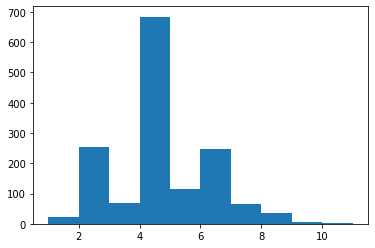

In [11]:
plt.hist(y_train.sum(axis=1))

FYI: Error rate of null policy (always predict 0)

In [12]:
y_test.sum()/(y_test.shape[0])

4.251908396946565

---

In [13]:
def micro_hammingloss(p,y):
    assert p.shape == y.shape
    pos = np.where( (p != y) & (y > 0) )
    neg = np.where( (p != y) & (y == 0) )
    fn = p[neg].sum()
    fp = (1-p[pos]).sum()
    return (fn+fp)/(p.shape[0])

In [14]:
def macro_hammingloss(test_probas, y_test):
    return np.mean([
        micro_hammingloss(test_probas[:,k].reshape((len(y_test),1)), 
                          y_test[:,k].reshape((len(y_test),1))) 
        for k in range(y_test.shape[1])
    ])

---
## Our Model

### CRM routines

In [33]:
class CRMDataset(object):
    
    def __init__(self):

        self.propensities_ = []
        self.actions_ = []
        self.rewards_ = []
        self.features_ = []
        
        self.propensities_np = None
        self.actions_np = None
        self.rewards_np = None
        self.features_np = None

        self.check()
        
    def __str__(self):
        if not self.propensities_np:
            return '<CRMDataset>'
        self._generate_numpys()
        return '<CRMDataset propensities:%s actions:%s rewards:%s features:%s>' % (
            self.propensities_np.shape,
            self.actions_np.shape,
            self.rewards_np.shape,
            self.features_np.shape
        )
    
    __repr__ = __str__
        
    def check(self):
        assert len(self.features_) == len(self.propensities_) == len(self.rewards_) == len(self.actions_)
        assert type(self.propensities_) == type(self.actions_) == type(self.rewards_) == type(self.features_) == list        
        
    def __len__(self):
        return len(self.propensities_)
    
    def _generate_numpys(self):
        if self.propensities_np is not None and len(self.propensities_np) == len(self.propensities_):
            return        
        self.propensities_np = np.vstack(self.propensities_)
        self.actions_np = np.vstack(self.actions_)
        self.rewards_np = np.vstack(self.rewards_)
        self.features_np = np.vstack(self.features_)
        
    @property
    def actions(self):
#         self._generate_numpys()
        return self.actions_np

    @property
    def propensities(self):
#         self._generate_numpys()
        return self.propensities_np
    
    @property
    def rewards(self):
#         self._generate_numpys()
        return self.rewards_np
    
    @property
    def features(self):
#         self._generate_numpys()
        return self.features_np
        
    def update_from_supervised_dataset(self, X, y, probas, n_samples=4, labels=labels):
        # X is (n,d)
        # y is (n,k)
        # probas is (n,k)

        assert len(X) == len(y) == len(probas), (len(X) , len(y) , len(probas))

        for i in range(len(X)):

            for k in range(n_samples):

                chosen_actions = np.array([np.random.binomial(1, p=probas[i,j]) for j in labels])
                self.actions_ += [chosen_actions]
                self.propensities_ += [probas[i,:]]
                self.features_ += [X[i,:]]
                # how do we scale that with chosen nber of actions ?
                self.rewards_ += [np.array([ y[i,j]*chosen_actions[j] for j in labels ])]
                
        self._generate_numpys()
        return self

### Modeling

In [17]:
def model_predict(beta, features):
    # beta is (k, d)
    # features is (n, d)
    p = np.dot(features, beta)
    p = expit(p)
    # predictions is (n,k)
    return p

In [60]:
def crm_loss(beta, crm_dataset: CRMDataset, clip: float = 1000, lambda_: float = 0):
    
    # sp.minimize flattens the beta matrix so better reshape it in case
    beta = beta.reshape((crm_dataset.features.shape[1], crm_dataset.actions.shape[1]))    
    
    predictions = model_predict(beta, crm_dataset.features)
    
    ips_weights = np.zeros(predictions.shape)
    taken_actions_idx = np.where(crm_dataset.actions > 0)
    ips_weights[taken_actions_idx] = predictions[taken_actions_idx] / crm_dataset.propensities[taken_actions_idx]
    ips_weights = np.clip(ips_weights, 0, clip)
    
    # SNIPS
    l = np.sum((1-crm_dataset.rewards)*ips_weights) / np.sum(ips_weights)
    
    if lambda_ > 0:
        # POEM loss
        l += lambda_ * np.std(ips_weights) / np.sqrt(features.shape[0])

    return l

In [61]:
def iterate_model(beta, X, y, sampling_probas, crm_dataset: CRMDataset, 
                  samples_per_instance:int = 4, verbose=False):
    
    # beta should be (d,k)
    # prior_crm_dataset will get extended
    
    assert beta.shape == (X.shape[1], y.shape[1])
    
    if verbose:
        print('CRM dataset:', len(crm_dataset), end='', file=sys.stderr)
    crm_dataset.update_from_supervised_dataset(
        X, y, sampling_probas, 
        n_samples=samples_per_instance
    )
    if verbose:
        print('->', len(crm_dataset), file=sys.stderr)
         
    if verbose:
        start_loss = crm_loss(beta, crm_dataset)
        print('Optim iteration - loss: %.4f -> ' % start_loss, 
              end='', file=sys.stderr)
    
    solution = sp_minimize(crm_loss, beta, args=(crm_dataset), method='L-BFGS-B')
    newbeta = solution.x.reshape((X.shape[1], y.shape[1]))  # sp.minimize flattens the beta matrix
    
    if verbose:
        final_loss = crm_loss(newbeta, crm_dataset)
        print('%.4f' % final_loss, file=sys.stderr)
    
    return newbeta

## Evaluation

In [21]:
def evaluate_model(beta, X_test, y_test, normalize=False, binarize=True):
    beta_test_probas = model_predict(beta, X_test)
    if normalize:
        beta_test_probas /= beta_test_probas.sum(axis=1).reshape((len(y_test),1))
    if binarize:
        beta_test_probas = (beta_test_probas > .5).astype(int)
    return micro_hammingloss(beta_test_probas, y_test)

----
## Baselines & Skylines

 ![Perf from CRM article](./basesky.png)

In [22]:
if dataset_name == 'tmc_2007':
    print("reducing dimension for TMC dataset")
    fh = GaussianRandomProjection(n_components=1000)
    X_train = fh.fit_transform(X_train)
    X_test = fh.transform(X_test)
    print(X_train.shape)

In [23]:
print("pi_null micro test loss:", micro_hammingloss(np.zeros(y_test.shape), y_test))

pi_null micro test loss: 4.251908396946565


In [24]:
pi_dummy = MultiOutputClassifier(DummyClassifier())
pi_dummy.fit(X_train, y_train)

print("pi_dummy train loss:", micro_hammingloss(pi_dummy.predict(X_train), y_train))
print("pi_dummy test loss:", micro_hammingloss(pi_dummy.predict(X_test), y_test))

pi_dummy train loss: 3.236
pi_dummy test loss: 3.261723009814613


/home/e.diemert/miniconda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [29]:
pi0 = MultiOutputClassifier(LogisticRegression(), n_jobs=6)

X_0, X_, y_0, y_ = train_test_split(X_train, y_train, test_size=.95, random_state=42)
print('learning pi0 on', len(X_0), 'data points')
pi0.fit(X_0, y_0)

print("pi0 train loss:", micro_hammingloss(pi0.predict(X_train), y_train))
l0 = micro_hammingloss(pi0.predict(X_test), y_test)
print("pi0 test loss:", l0)

learning pi0 on 75 data points
pi0 train loss: 3.028
pi0 test loss: 3.134133042529989


In [30]:
pistar = MultiOutputClassifier(LogisticRegressionCV(max_iter=10000, n_jobs=6))
pistar.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegressionCV(max_iter=10000, n_jobs=6))

In [31]:
print("pi* train loss:", micro_hammingloss(pistar.predict(X_train), y_train))
lstar = micro_hammingloss(pistar.predict(X_test), y_test)
print("pi* test loss:", lstar)

pi* train loss: 2.6293333333333333
pi* test loss: 2.7906215921483097


In [34]:
ref_crm_dataset = CRMDataset().update_from_supervised_dataset(
    X_train, y_train, 
    np.ones((X_train.shape[0], y_train.shape[1]))*.5,
    n_samples=40
)

---
## Sequential CRM

In [81]:
class LossHistory(object):
    
    def __init__(self, name, ref_crm_dataset, X_test, y_test):
        self.name = name
        self.ref_crm_dataset = ref_crm_dataset
        self.X_test = X_test
        self.y_test = y_test
        self.hamming_loss = []
        self.crm_loss = []
        self.unif_crm_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.rewards = []
        
    def update(self, beta, crm_dataset):
        self.betas += [beta]
        self.hamming_loss += [evaluate_model(beta, self.X_test, self.y_test)]
        self.crm_loss += [crm_loss(beta, crm_dataset)]
        self.unif_crm_loss += [crm_loss(beta, self.ref_crm_dataset)]
        self.n_samples += [len(crm_dataset)]
        self.n_actions += [np.sum(crm_dataset.actions_)]
        self.rewards += [np.sum(crm_dataset.rewards_)]
        
    def show_last(self):
        print(
            '<', self.name,
            'Ham. loss: %.5f' % self.hamming_loss[-1], 
            'CRM loss: %.5f' % self.crm_loss[-1],
            'CRM loss (U): %.5f' % self.unif_crm_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % self.n_samples[-1],
            '|A|=%d' % self.n_actions[-1],
            '|R|=%d' % self.rewards[-1],
            '>',
            file=sys.stderr
        )

In [82]:
beta_init = np.random.normal(size=(X_train.shape[1], len(labels)))*0+1
print('beta0 H. loss:', evaluate_model(beta_init, X_test, y_test))
print('beta0 CRM Loss (unif):', crm_loss(beta_init, ref_crm_dataset))

beta0 H. loss: 6.812431842966194
beta0 CRM Loss (unif): 0.7006134543964074


In [ ]:
beta_static = beta_init.copy()
beta_dynamic = beta_init.copy()

static_crm_dataset = CRMDataset()
dynamic_crm_dataset = CRMDataset()

static_loss_history = LossHistory("Static", ref_crm_dataset, X_test, y_test)
dynamic_loss_history = LossHistory("Dynamic", ref_crm_dataset, X_test, y_test)

epochs = 1
n_episods = 10
batch = int(len(X_train) / n_episods)
replays = 4

t_end = t_start = time.time()
for _ in range(epochs):
    
    print('*'*30, 'PASS %d/%d'% (_+1, epochs), '*'*30, file=sys.stderr)
    for episod in range(n_episods):
        
        t_end = time.time()
        start = episod*batch
        end = (episod+1)*batch
        print('*'*20, 'episod: %d/%d' % (episod+1, n_episods), 'time: %ds' % (t_end - t_start), '*'*20, file=sys.stderr)
        t_start = time.time()

        # current slice of dataset
        X = X_train[start:end,:]
        y = y_train[start:end,:]
       
        #### static CRM 
        ## action probas
        sampling_probas_static = pi0.predict_proba(X)
        sampling_probas_static = np.array([_[:,1] for _ in sampling_probas_static]).T
        ## optimize
        beta_static = iterate_model(
            beta_static, X, y, sampling_probas_static, static_crm_dataset, 
            samples_per_instance=replays,
        )
        ## record
        static_loss_history.update(beta_static, static_crm_dataset)
        static_loss_history.show_last()
        
        #### sequential CRM 
        ## action probas
        if episod == 0:
            sampling_probas_dynamic = sampling_probas_static
        else:
            sampling_probas_dynamic = model_predict(beta_dynamic, X)        
        ## optimize
        beta_dynamic = iterate_model(
            beta_dynamic, X, y, sampling_probas_dynamic, dynamic_crm_dataset,
            samples_per_instance=replays,
        )
        ## record
        dynamic_loss_history.update(beta_dynamic, dynamic_crm_dataset)
        dynamic_loss_history.show_last()

****************************** PASS 1/1 ******************************
******************** episod: 1/10 time: 0s ********************
< Static Ham. loss: 6.12868 CRM loss: 0.22121 CRM loss (U): 0.63026 |beta|=365.03 n=600 |A|=2454 |R|=1202 >


In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(static_loss_history.crm_loss, '--', label='CRM loss (static)')
ax.plot(dynamic_loss_history.crm_loss, '--', label='CRM loss (dynamic)')
ax.plot(static_loss_history.unif_crm_loss, '--', label='unif. CRM loss (static)')
ax.plot(dynamic_loss_history.unif_crm_loss, '--', label='unif. CRM loss (dynamic)')
ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(static_loss_history.hamming_loss, label='Hamming loss (static)')
ax2.plot(dynamic_loss_history.hamming_loss, label='Hamming loss (dynamic)')
ax2.set_ylabel('Hamming Loss')
ax2.legend(loc='lower left')

In [ ]:
plt.title('Avg Proba per Action')
plt.plot(expit(beta_static.mean(axis=0)),'--', label='static')
plt.plot(expit(beta_dynamic.mean(axis=0)),'--', label='dynamic')
plt.legend()

In [ ]:
plt.title('Avg Proba per Feature')
plt.plot(expit(beta_static.mean(axis=1)),'--', label='static')
plt.plot(expit(beta_dynamic.mean(axis=1)),'--', label='dynamic')
plt.legend()

In [ ]:
plt.title('Sampling Probas per Action')
plt.plot(sampling_probas_static.mean(axis=0),'--', label='static')
plt.plot(sampling_probas_dynamic.mean(axis=0),'--', label='dynamic')
plt.plot(y_test.mean(axis=0), label='label average', alpha=.5)
plt.legend()